In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [ ]:
import os
import numpy as np
import nibabel as nib
import tensorflow as tf
from tensorflow.keras.layers import Conv3D, MaxPooling3D, UpSampling3D, concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split

# Modify the paths to point to your dataset in Google Drive
image_path = "/content/drive/MyDrive/Task03_Liver_rs/images"
label_path = "/content/drive/MyDrive/Task03_Liver_rs/labels"
TARGET_SHAPE = (64, 64, 64)  # Resize target (Depth, Height, Width)

In [ ]:
# ✅ Step 2: Load NIfTI Files
def load_nifti_files(image_dir, label_dir, target_shape):
    images, labels = [], []

    for img_file, lbl_file in zip(sorted(os.listdir(image_dir)), sorted(os.listdir(label_dir))):
        img_data = nib.load(os.path.join(image_dir, img_file)).get_fdata()
        lbl_data = nib.load(os.path.join(label_dir, lbl_file)).get_fdata()

        # Resize using SciPy (important for 3D images)
        img_data = resize_3d_image(img_data, target_shape)
        lbl_data = resize_3d_image(lbl_data, target_shape)

        images.append(img_data)
        labels.append(lbl_data)

    return np.array(images), np.array(labels)

def resize_3d_image(image, target_shape):
    """ Resize 3D image (Depth, Height, Width) using nearest-neighbor interpolation """
    factors = [t / s for t, s in zip(target_shape, image.shape)]
    return zoom(image, factors, order=0)  # Nearest-neighbor (good for label masks)

In [ ]:
# ✅ Step 3: Preprocess Data
def preprocess_data(images, labels):
    images = images / np.max(images)  # Normalize images to [0, 1]
    labels = (labels > 0).astype(np.uint8)  # Convert labels to binary (0 or 1)
    images = images[..., np.newaxis]  # Add channel dimension
    labels = labels[..., np.newaxis]
    return images, labels

In [ ]:
# ✅ Step 4: Split Data (Train/Test)
def split_data(images, labels, test_size=0.2):
    return train_test_split(images, labels, test_size=test_size, random_state=42)


In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """
    Dice coefficient for binary classification.
    y_true: Ground truth labels
    y_pred: Predicted labels
    smooth: A small constant to avoid division by zero
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return (2. * intersection + smooth) / (union + smooth)


In [ ]:
from tensorflow.keras.layers import Conv3D, MaxPooling3D, UpSampling3D, concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_3d_unet(input_shape=(64, 64, 64, 1)):  # Use smaller input shape if necessary
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv3D(16, (3,3,3), activation="relu", padding="same")(inputs)
    c1 = Conv3D(16, (3,3,3), activation="relu", padding="same")(c1)
    p1 = MaxPooling3D((2,2,2))(c1)

    c2 = Conv3D(32, (3,3,3), activation="relu", padding="same")(p1)
    c2 = Conv3D(32, (3,3,3), activation="relu", padding="same")(c2)
    p2 = MaxPooling3D((2,2,2))(c2)
    # Decoder (same structure)
    u5 = UpSampling3D((2,2,2))(c2)
    u5 = concatenate([u5, c1])
    c5 = Conv3D(32, (3,3,3), activation="relu", padding="same")(u5)
    c5 = Conv3D(32, (3,3,3), activation="relu", padding="same")(c5)

    outputs = Conv3D(1, (1,1,1), activation="sigmoid")(c5)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[dice_coefficient])

    return model


In [ ]:
# ✅ Step 6: Run the Pipeline
print("Loading data...")
images, labels = load_nifti_files(image_path, label_path, TARGET_SHAPE)

print("Preprocessing data...")
images, labels = preprocess_data(images, labels)

print("Splitting dataset...")
X_train, X_test, y_train, y_test = split_data(images, labels)

print("Building model...")
model = build_3d_unet()

print("Compiling model...")
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

print("Starting training...")
history = model.fit(X_train, y_train, epochs=20, batch_size=1, validation_data=(X_test, y_test))

print("Training complete")

Loading data...
Preprocessing data...
Splitting dataset...
Building model...
Compiling model...
Starting training...
Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9338 - loss: 0.2885 - val_accuracy: 0.9732 - val_loss: 0.0855
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.9734 - loss: 0.0925 - val_accuracy: 0.9732 - val_loss: 0.0789
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.9716 - loss: 0.0800 - val_accuracy: 0.9732 - val_loss: 0.0567
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.9664 - loss: 0.0763 - val_accuracy: 0.9732 - val_loss: 0.0497
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.9794 - loss: 0.0463 - val_accuracy: 0.9846 - val_loss: 0.0529
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.9805 - loss: 0.0609 - val_accuracy: 0.9854 - val_loss: 0.0413
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.9850 - loss: 0.0416 - val_accuracy: 0.9819 - val_

In [ ]:
# Save the model to a file (in this case, in the current directory of Colab)
model.save("/content/3d_unet_model.h5")

print("Model saved successfully!")

Model saved successfully!


2/2 ━━━━━━━━━━━━━━━━━━━━ 52s 24s/step


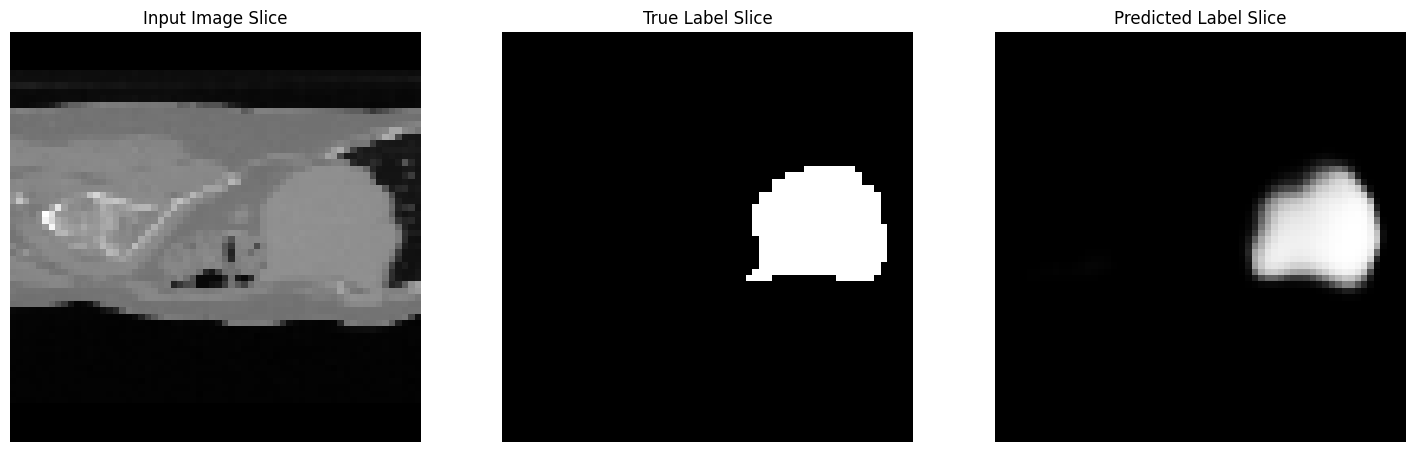

In [ ]:
image_index = 0  # Replace with the desired index
slice_index = 50
predictions = model.predict(images)

def visualize_before_after(image, true_label, predicted_label, slice_index=50):
    """ Visualize raw image, true label, and predicted label side-by-side """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Show raw image slice
    axes[0].imshow(image[slice_index, :, :], cmap="gray")
    axes[0].set_title("Input Image Slice")
    axes[0].axis("off")

    # Show true label slice
    axes[1].imshow(true_label[slice_index, :, :], cmap="gray")
    axes[1].set_title("True Label Slice")
    axes[1].axis("off")

    # Show predicted label slice
    axes[2].imshow(predicted_label[slice_index, :, :], cmap="gray")
    axes[2].set_title("Predicted Label Slice")
    axes[2].axis("off")

    plt.show()



# Example usage: Compare before vs after
visualize_before_after(images[image_index], labels[image_index], predictions[image_index, ..., 0])


Prediction file not found at C:\Users\Inayaimtiyaz\OneDrive\Desktop\Segmentation\UNet_Predicted_Masks\predicted_mask_liver_50.nii.gz


C:\Users\Inayaimtiyaz\AppData\Local\Temp\ipykernel_24960\1031698700.py:205: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


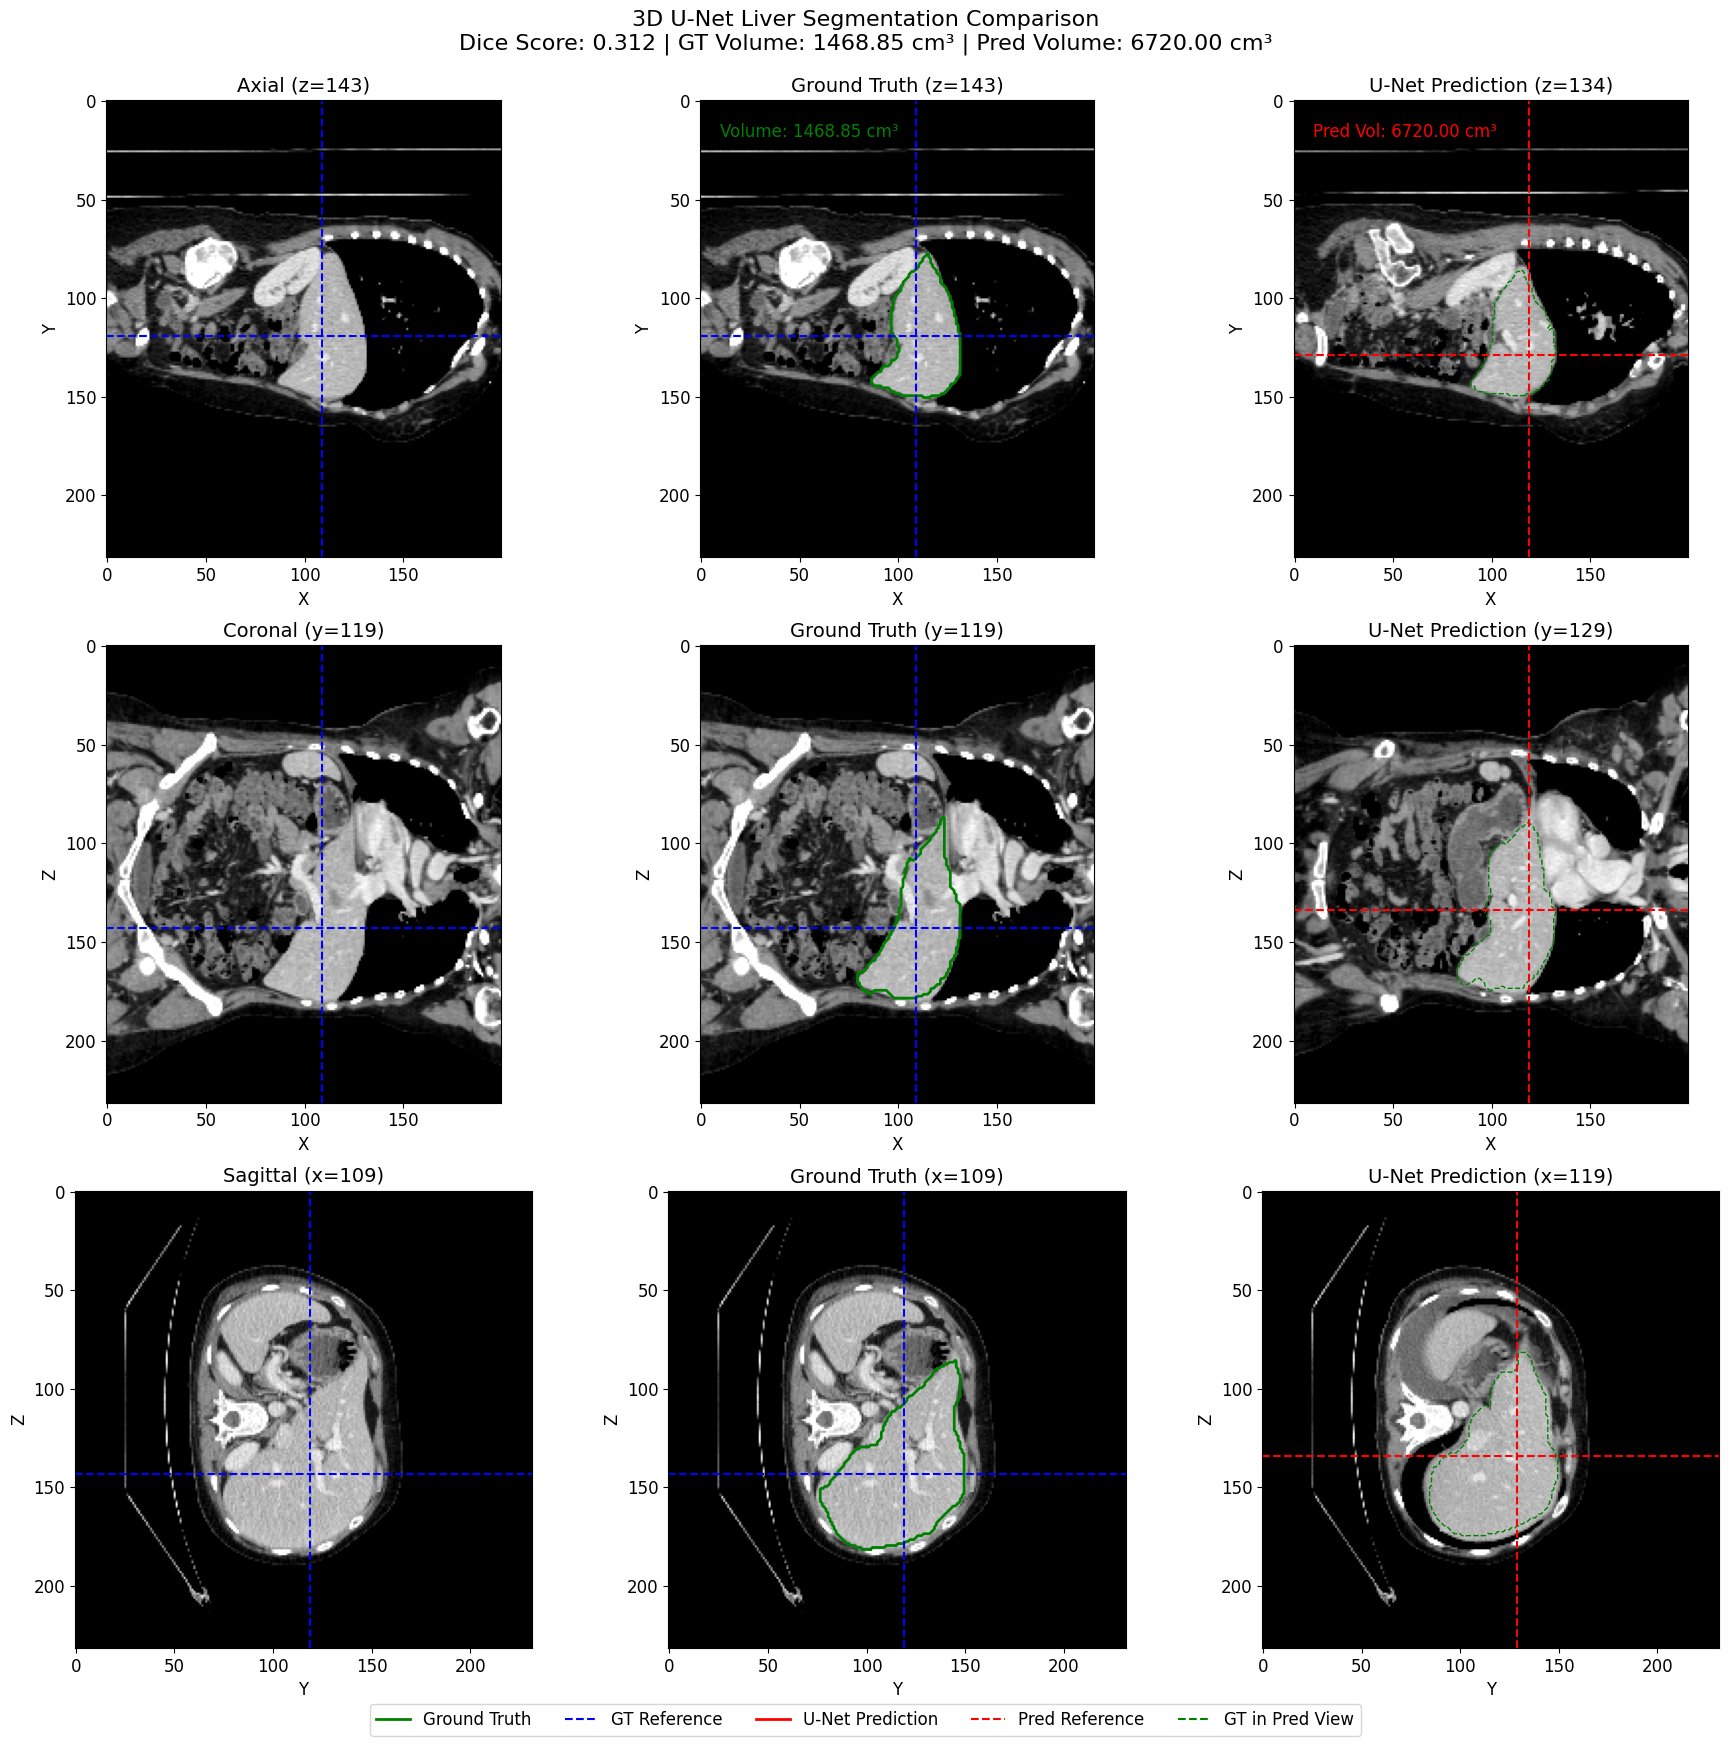

In [11]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from skimage import measure
import matplotlib

# Set larger font sizes for better readability
matplotlib.rcParams.update({'font.size': 12})

# -----------------------------
# 1. Load the Data
# -----------------------------
# Original image (e.g., CT scan)
orig_path = r"C:\Users\Inayaimtiyaz\OneDrive\Desktop\Segmentation\Dataset\08-3D-Liver-Tumor-Segmentation\Task03_Liver_rs\images\liver_50.nii"
orig_nii = nib.load(orig_path)
orig_data = orig_nii.get_fdata()

# Ground truth label segmentation
label_path = r"C:\Users\Inayaimtiyaz\OneDrive\Desktop\Segmentation\Dataset\08-3D-Liver-Tumor-Segmentation\Task03_Liver_rs\labels\liver_50.nii"
label_nii = nib.load(label_path)
label_data = label_nii.get_fdata()

# Predicted segmentation mask - update this path to your U-Net prediction
pred_path = r"C:\Users\Inayaimtiyaz\OneDrive\Desktop\Segmentation\UNet_Predicted_Masks\predicted_mask_liver_50.nii.gz"
try:
    pred_nii = nib.load(pred_path)
    pred_data = pred_nii.get_fdata()
    print(f"Loaded prediction from {pred_path}")
except FileNotFoundError:
    print(f"Prediction file not found at {pred_path}")
    # Create dummy prediction for testing visualization
    pred_data = np.zeros_like(orig_data)
    # Randomly mark some areas as liver (for demonstration)
    pred_data[100:170, 80:180, 80:160] = 1

# -----------------------------
# 2. Normalize the Original Image for Better Display
# -----------------------------
# Use window-level technique for better CT visualization
def window_image(img, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    windowed_img = np.clip(img, img_min, img_max)
    windowed_img = (windowed_img - img_min) / (img_max - img_min)
    return windowed_img

# Window settings for abdominal CT (liver)
windowed_img = window_image(orig_data, window_center=50, window_width=350)

# -----------------------------
# 3. Find Centers and Calculate Metrics
# -----------------------------
# Calculate center points for ground truth
gt_indices = np.where(label_data > 0.5)
if len(gt_indices[0]) > 0:
    z_c_gt = int(np.mean(gt_indices[0]))
    y_c_gt = int(np.mean(gt_indices[1]))
    x_c_gt = int(np.mean(gt_indices[2]))
else:
    z_c_gt, y_c_gt, x_c_gt = [s // 2 for s in orig_data.shape]

# Calculate center points for prediction
pred_indices = np.where(pred_data > 0.5)
if len(pred_indices[0]) > 0:
    z_c_pred = int(np.mean(pred_indices[0]))
    y_c_pred = int(np.mean(pred_indices[1]))
    x_c_pred = int(np.mean(pred_indices[2]))
else:
    z_c_pred, y_c_pred, x_c_pred = [s // 2 for s in orig_data.shape]

# Calculate Dice coefficient to quantify overlap
def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-6)  # Add small epsilon to avoid division by zero

dice_score = dice_coefficient(label_data, pred_data)

# Calculate volumes
voxel_volume = np.prod(orig_nii.header.get_zooms())  # mm³
gt_volume = np.sum(label_data) * voxel_volume / 1000  # Convert to cm³
pred_volume = np.sum(pred_data) * voxel_volume / 1000  # Convert to cm³

# -----------------------------
# 4. Create Visualization Grid for Original, GT, and Prediction
# -----------------------------
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 18))
row_titles = ['Axial', 'Coronal', 'Sagittal']
col_titles = ['Original Image', 'Ground Truth', 'U-Net Prediction']

# Function to draw segmentation contours with custom appearance
def draw_segmentation_contours(ax, slice_data, color, linewidth=1.5, linestyle='-'):
    # Find contours at a constant value of 0.5
    contours = measure.find_contours(slice_data, 0.5)
    
    # Plot contours as lines
    for contour in contours:
        if len(contour) > 2:  # Only plot contours with at least 3 points
            ax.plot(contour[:, 1], contour[:, 0], color=color, linewidth=linewidth, linestyle=linestyle)

# --- Axial View (Top row) ---
# Original Image
axes[0, 0].imshow(windowed_img[z_c_gt, :, :], cmap='gray')
axes[0, 0].axvline(x=x_c_gt, color='blue', linestyle='--')
axes[0, 0].axhline(y=y_c_gt, color='blue', linestyle='--')
axes[0, 0].set_title(f'Axial (z={z_c_gt})', fontsize=14)
axes[0, 0].set_xlabel("X")
axes[0, 0].set_ylabel("Y")

# Ground Truth
axes[0, 1].imshow(windowed_img[z_c_gt, :, :], cmap='gray')
draw_segmentation_contours(axes[0, 1], label_data[z_c_gt, :, :], color='green', linewidth=2)
axes[0, 1].axvline(x=x_c_gt, color='blue', linestyle='--')
axes[0, 1].axhline(y=y_c_gt, color='blue', linestyle='--')
axes[0, 1].set_title(f'Ground Truth (z={z_c_gt})', fontsize=14)
axes[0, 1].set_xlabel("X")
axes[0, 1].set_ylabel("Y")
axes[0, 1].text(0.05, 0.95, f"Volume: {gt_volume:.2f} cm³", 
                transform=axes[0, 1].transAxes, color='green', 
                fontsize=12, verticalalignment='top')

# U-Net Prediction
axes[0, 2].imshow(windowed_img[z_c_pred, :, :], cmap='gray')
#draw_segmentation_contours(axes[0, 2], pred_data[z_c_pred, :, :], color='red', linewidth=2)
draw_segmentation_contours(axes[0, 2], label_data[z_c_pred, :, :], color='green', linewidth=1, linestyle='--')
axes[0, 2].axvline(x=x_c_pred, color='red', linestyle='--')
axes[0, 2].axhline(y=y_c_pred, color='red', linestyle='--')
axes[0, 2].set_title(f'U-Net Prediction (z={z_c_pred})', fontsize=14)
axes[0, 2].set_xlabel("X")
axes[0, 2].set_ylabel("Y")
axes[0, 2].text(0.05, 0.95, f"Pred Vol: {pred_volume:.2f} cm³", 
                transform=axes[0, 2].transAxes, color='red', 
                fontsize=12, verticalalignment='top')

# --- Coronal View (Middle row) ---
# Original Image
axes[1, 0].imshow(windowed_img[:, y_c_gt, :], cmap='gray')
axes[1, 0].axvline(x=x_c_gt, color='blue', linestyle='--')
axes[1, 0].axhline(y=z_c_gt, color='blue', linestyle='--')
axes[1, 0].set_title(f'Coronal (y={y_c_gt})', fontsize=14)
axes[1, 0].set_xlabel("X")
axes[1, 0].set_ylabel("Z")

# Ground Truth
axes[1, 1].imshow(windowed_img[:, y_c_gt, :], cmap='gray')
draw_segmentation_contours(axes[1, 1], label_data[:, y_c_gt, :], color='green', linewidth=2)
axes[1, 1].axvline(x=x_c_gt, color='blue', linestyle='--')
axes[1, 1].axhline(y=z_c_gt, color='blue', linestyle='--')
axes[1, 1].set_title(f'Ground Truth (y={y_c_gt})', fontsize=14)
axes[1, 1].set_xlabel("X")
axes[1, 1].set_ylabel("Z")

# U-Net Prediction
axes[1, 2].imshow(windowed_img[:, y_c_pred, :], cmap='gray')
#draw_segmentation_contours(axes[1, 2], pred_data[:, y_c_pred, :], color='red', linewidth=2)
draw_segmentation_contours(axes[1, 2], label_data[:, y_c_pred, :], color='green', linewidth=1, linestyle='--')
axes[1, 2].axvline(x=x_c_pred, color='red', linestyle='--')
axes[1, 2].axhline(y=z_c_pred, color='red', linestyle='--')
axes[1, 2].set_title(f'U-Net Prediction (y={y_c_pred})', fontsize=14)
axes[1, 2].set_xlabel("X")
axes[1, 2].set_ylabel("Z")

# --- Sagittal View (Bottom row) ---
# Original Image
axes[2, 0].imshow(windowed_img[:, :, x_c_gt], cmap='gray')
axes[2, 0].axvline(x=y_c_gt, color='blue', linestyle='--')
axes[2, 0].axhline(y=z_c_gt, color='blue', linestyle='--')
axes[2, 0].set_title(f'Sagittal (x={x_c_gt})', fontsize=14)
axes[2, 0].set_xlabel("Y")
axes[2, 0].set_ylabel("Z")

# Ground Truth
axes[2, 1].imshow(windowed_img[:, :, x_c_gt], cmap='gray')
draw_segmentation_contours(axes[2, 1], label_data[:, :, x_c_gt], color='green', linewidth=2)
axes[2, 1].axvline(x=y_c_gt, color='blue', linestyle='--')
axes[2, 1].axhline(y=z_c_gt, color='blue', linestyle='--')
axes[2, 1].set_title(f'Ground Truth (x={x_c_gt})', fontsize=14)
axes[2, 1].set_xlabel("Y")
axes[2, 1].set_ylabel("Z")

# U-Net Prediction
axes[2, 2].imshow(windowed_img[:, :, x_c_pred], cmap='gray')
#draw_segmentation_contours(axes[2, 2], pred_data[:, :, x_c_pred], color='red', linewidth=2)
draw_segmentation_contours(axes[2, 2], label_data[:, :, x_c_pred], color='green', linewidth=1, linestyle='--')
axes[2, 2].axvline(x=y_c_pred, color='red', linestyle='--')
axes[2, 2].axhline(y=z_c_pred, color='red', linestyle='--')
axes[2, 2].set_title(f'U-Net Prediction (x={x_c_pred})', fontsize=14)
axes[2, 2].set_xlabel("Y")
axes[2, 2].set_ylabel("Z")

# Add legend for all plots
legend_ax = fig.add_axes([0.25, 0.02, 0.5, 0.02])
legend_ax.axis('off')
legend_ax.plot([], [], color='green', linewidth=2, label='Ground Truth')
legend_ax.plot([], [], color='blue', linestyle='--', label='GT Reference')
legend_ax.plot([], [], color='red', linewidth=2, label='U-Net Prediction')
legend_ax.plot([], [], color='red', linestyle='--', label='Pred Reference')
legend_ax.plot([], [], color='green', linestyle='--', label='GT in Pred View')
legend_ax.legend(loc='center', ncol=5, fontsize=12)

# Add metrics as a figure title
plt.suptitle(f"3D U-Net Liver Segmentation Comparison\nDice Score: {dice_score:.3f} | GT Volume: {gt_volume:.2f} cm³ | Pred Volume: {pred_volume:.2f} cm³", 
             fontsize=16)

plt.tight_layout()
plt.subplots_adjust(top=0.93, bottom=0.07)  # Make room for the title and legend
plt.savefig("liver_segmentation_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# ============================================= CODE ENDS HERE ========================================================================

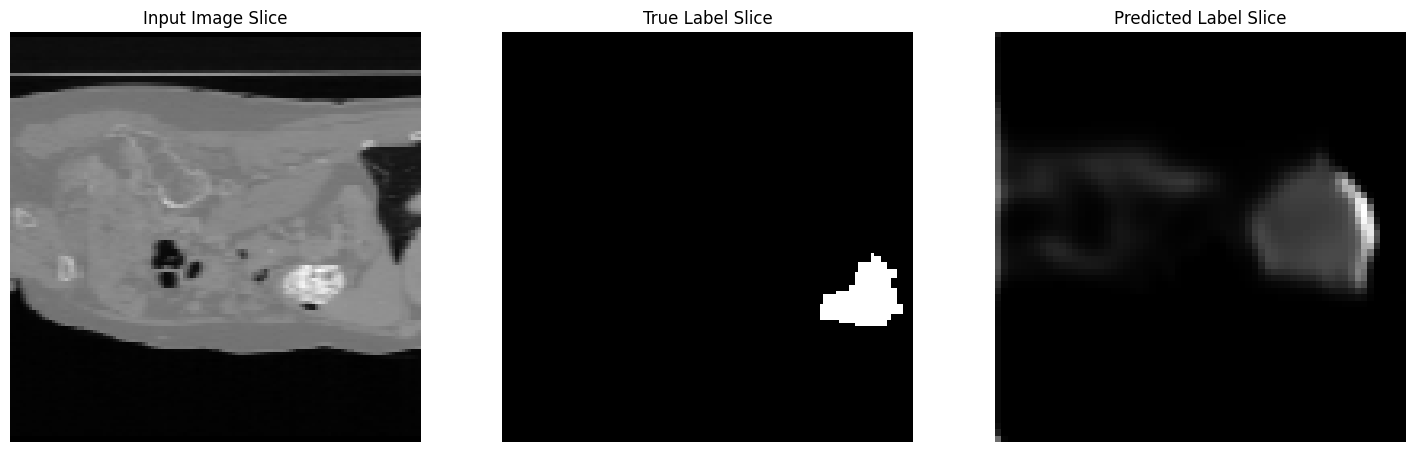

In [ ]:
  # 128 batch size with dice method

def visualize_before_after(image, true_label, predicted_label, slice_index=50):
    """ Visualize raw image, true label, and predicted label side-by-side """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Show raw image slice
    axes[0].imshow(image[slice_index, :, :], cmap="gray")
    axes[0].set_title("Input Image Slice")
    axes[0].axis("off")

    # Show true label slice
    axes[1].imshow(true_label[slice_index, :, :], cmap="gray")
    axes[1].set_title("True Label Slice")
    axes[1].axis("off")

    # Show predicted label slice
    axes[2].imshow(predicted_label[slice_index, :, :], cmap="gray")
    axes[2].set_title("Predicted Label Slice")
    axes[2].axis("off")

    plt.show()

# Example usage: Compare before vs after
visualize_before_after(images[image_index], labels[image_index], predictions[image_index, ..., 0])


In [ ]:
#OVERFITTING HAPPENED ^